In [49]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.kernels import *
from gpytorch.module import Module
from gpytorch.priors import *
from gpytorch.mlls import ExactMarginalLogLikelihood
import botorch
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.tensor([0, 0.1, 0.25, 0.3, 0.5, 0.6, 0.75, 0.9, 1])
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi))# + torch.randn(train_x.size()) * math.sqrt(0.04)
candid_x = torch.tensor([0.05, 0.27, 0.6, 0.8])
candid_y = torch.sin(candid_x * (2 * math.pi))
plot_x = torch.linspace(0, 1, 100)
plot_y = torch.sin(plot_x * (2 * math.pi))# + torch.randn(plot_x.size()) * math.sqrt(0.04)

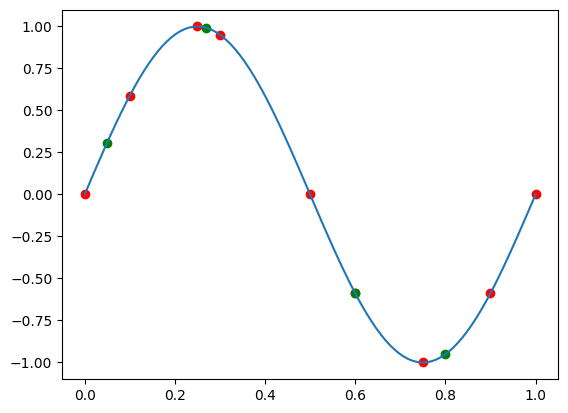

In [50]:
plt.plot(plot_x, plot_y)
plt.scatter(train_x, train_y, color="r")
plt.scatter(candid_x, candid_y, color="g")

In [51]:
# initialize likelihood and model
kernel = ScaleKernel(
    RBFKernel(lengthscale_prior=LogNormalPrior(0.1, 5.0)),
    outputscale_prior=NormalPrior(1.0, 5.0),
)
model = botorch.models.SingleTaskGP(
    torch.tensor(train_x.unsqueeze(-1)).double(),
    torch.tensor(train_y.unsqueeze(-1)).double(),
    covar_module=kernel,
)
likelihood = ExactMarginalLogLikelihood(model.likelihood, model)

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_35868/2674308477.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_x.unsqueeze(-1)).double(),
/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_35868/2674308477.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_y.unsqueeze(-1)).double(),


In [54]:
botorch.fit.fit_gpytorch_model(likelihood)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): LogNormalPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): NormalPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

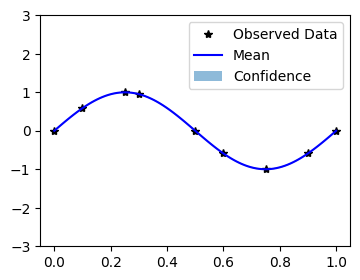

In [59]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
preds = model.posterior(plot_x)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = preds.mvn.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(plot_x.numpy(), preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(plot_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [69]:
from botorch.generation.sampling import MaxPosteriorSampling
from botorch.acquisition import ExpectedImprovement
EI = ExpectedImprovement(model, best_f=1)
acquisition_function = MaxPosteriorSampling(model=model, replacement=False)
print(candid_x.unsqueeze(-1).unsqueeze(0).shape)
TS_candid = acquisition_function(candid_x.unsqueeze(-1).unsqueeze(0))
EI_candid = candid_x[torch.argmax(EI(candid_x.unsqueeze(-1).unsqueeze(-1)))]
print(EI_candid)
print(TS_candid)

torch.Size([1, 4, 1])
tensor(0.2700)
tensor([[[0.2700]]])


In [70]:
model = -model

TypeError: bad operand type for unary -: 'SingleTaskGP'